In [1]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc, \
precision_score, recall_score, f1_score, accuracy_score, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers



Download the data from Kaggle:

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The time is seconds elapsed over two days, so normalize to one day.

In [4]:
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)

In [5]:
df.shape

(284807, 31)

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,14.537951,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,5.847061,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,10.598194,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,15.010833,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,19.329722,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,23.999444,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# no missing data!
df.isnull().sum().any()

False

In [8]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes

0    284315
1       492
Name: Class, dtype: int64

In [9]:
#There is a severe class imbalance!
fraud = df[df['Class'] == 1]
real = df[df['Class'] == 0]

In [10]:
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,12.136986,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,6.719614,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,0.112778,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,5.923819,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,12.052361,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,17.803681,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,23.993333,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


In [11]:
real.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,14.542106,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,5.844597,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,...,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,10.601389,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,...,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,15.014167,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,...,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,19.332778,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,...,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,23.999444,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


Let's look at amounts spent in both fraud and real transactions.

The fraudulent transactions had a higher mean amount (122) than real transactions (88).

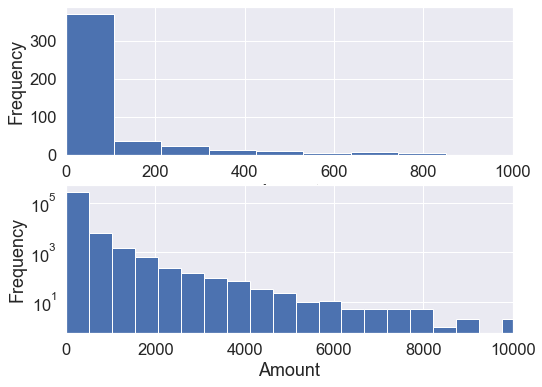

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
ax1.hist(fraud.Amount,bins=20)
ax1.set_xlabel('Amount')
ax1.set_ylabel('Frequency')
ax1.set_xlim([0,1000])
ax2.hist(real.Amount,bins=50)
ax2.set_xlabel('Amount')
ax2.set_ylabel('Frequency')
ax2.set_yscale('log')
ax2.set_xlim([0,10000])
plt.show()

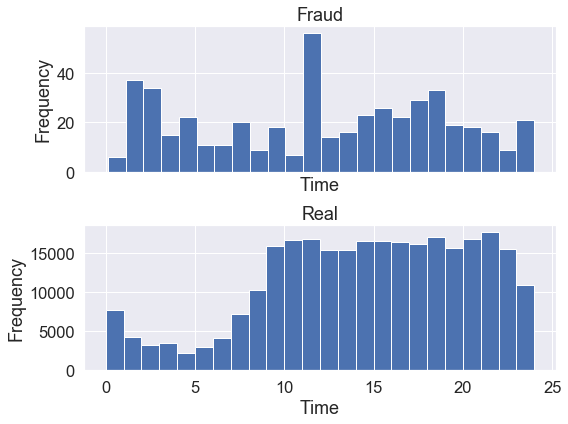

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True)
ax1.hist(fraud['Time'], bins=24)
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax1.set_title('Fraud')
ax2.hist(real['Time'], bins=24, label = 'Real')
ax2.set_xlabel('Time')
ax2.set_ylabel('Frequency')
ax2.set_title('Real')
plt.tight_layout()
plt.show()

The real transactions are distributed in time during normal waking hours. Tere seems to be a peak at noon for fraudulent actions as is more uniformly distributed throughout the day.

Let's visualize using TSNE using a subsample of the points

In [14]:
realSample = real.sample(1000, random_state=42)
smp = realSample.append(fraud)
X = smp.drop(['Class'], axis=1).values
Y = smp['Class'].values

In [15]:
tsne = TSNE(n_components=2, random_state=42)
X_tf = tsne.fit_transform(X)

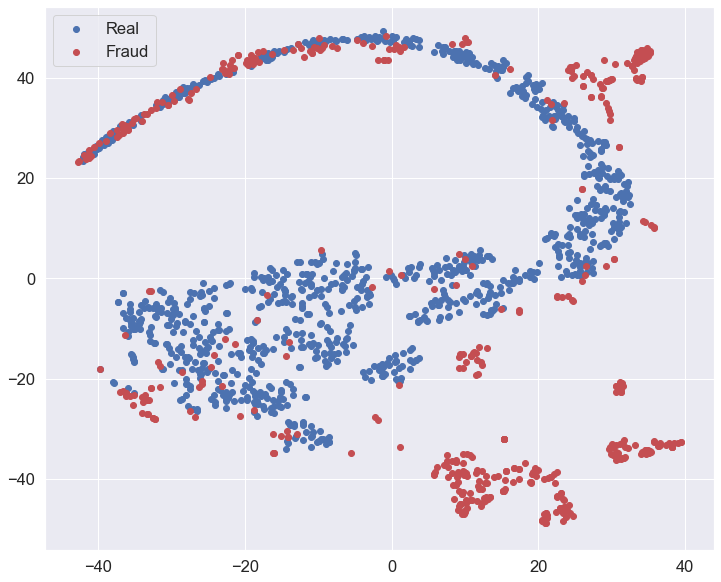

In [16]:
plt.figure(figsize=(12,10))
plt.scatter(X_tf[np.where(Y==0),0] , X_tf[np.where(Y==0), 1], color = 'b', label= 'Real')
plt.scatter(X_tf[np.where(Y==1),0] , X_tf[np.where(Y==1), 1], color = 'r', label = 'Fraud')
plt.legend()
plt.show()

Some of the frauds are well separated, but many seem like real transactions.

### Data preprocessing

We split the real transactions into an 80-20 training and test set and then use a standard scaler.

In [17]:
X_train, X_test = train_test_split(real.drop(['Class'], axis=1), test_size=.2, random_state=42)

In [18]:
y = df['Class'].values

In [19]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train.values)
X_test_scale = scaler.transform(X_test.values)
X_fraud_scale = scaler.transform(fraud.drop(['Class'], axis=1))

### Autoencoder network

Autoencoders are feed forward neural networks much like multilayer perceptrons, but the architecture is such that the input layer and output layer are the same size and there is a "yo-yo" type structure to the hidden layers. The first half of the "yo-yo" is called the encoder network and the other half is called the decoder network. The latent representation is built in the hidden layers. Ideally, the reconstruction error would be low if a good representation was learned. 

We will train our model only on the real transactions only so that the encoder learns representation of real transactions.

In [20]:
def denseBlock(units, alpha=0., bn=False):
    def f(x):
        x = Dense(units)(x)
        x = LeakyReLU(alpha=alpha)(x)
        if bn:
            x = BatchNormalization()(x)
        return x
    return f

hidden = (128,64)
latent_dim = 16 
alpha = 0.
bn = False 

in_ = x = Input((X_train_scale.shape[1],))
for units in hidden:
    x = denseBlock(units, alpha, bn)(x)
x = z = Dense(latent_dim, name='embedding')(x)
for units in hidden[::-1]:
    x = denseBlock(units, alpha, bn)(x)
out_ = Dense(X_train_scale.shape[1], activation='linear')(x)
autoencoder = Model(in_, out_)

autoencoder.compile(optimizer="adam", loss="mse")
checkpoint = ModelCheckpoint(filepath="creditcardmodelx.h5",
                               verbose=0,
                               save_best_only=True)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
embedding (Dense)            (None, 16)                1040      
______________________

In [21]:
history = autoencoder.fit(X_train_scale, X_train_scale,
                    epochs=20,
                    batch_size=64,
                    shuffle=True,
                    validation_split = 0.20,
                    verbose=1,
                    callbacks=[checkpoint]).history

Train on 181961 samples, validate on 45491 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
181961/181961 [==============================] - 16s 90us/sample - loss: 0.1668 - val_loss: 0.0775
Epoch 2/20
181961/181961 [==============================] - 14s 75us/sample - loss: 0.0636 - val_loss: 0.0472
Epoch 3/20
181961/181961 [==============================] - 13s 73us/sample - loss: 0.0479 - val_loss: 0.0511
Epoch 4/20
181961/181961 [==============================] - 13s 74us/sample - loss: 0.0419 - val_loss: 0.0394
Epoch 5/20
181961/181961 [==============================] - 14s 74us/sample - loss: 0.0363 - val_loss: 0.0315
Epoch 6/20
181961/181961 [==============================] - 14s 74us/sample - loss: 0.0324 - val_loss: 0.0275
Epoch 7/20
181961/181961 [==============================] - 13s 74us/sample - loss: 0.0301 - val_loss: 0.0759
Epoch 8/20
181961/181961 [==============================] - 13s 73us/sample - loss: 0.0305 - val_loss: 0.0468
Epoch 9/20
181961/181

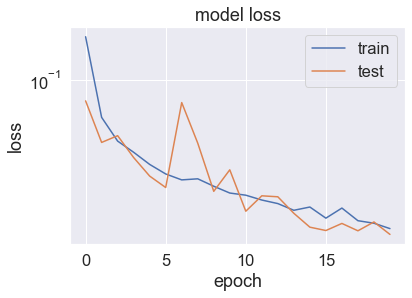

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.yscale('log')

In [23]:
autoencoder = load_model('creditcardmodelx.h5')

In [24]:
predictions_test = autoencoder.predict(X_test_scale)

mse_test = np.mean(np.power(X_test_scale - predictions_test, 2), axis=1)

predictions_train = autoencoder.predict(X_train_scale)

mse_train = np.mean(np.power(X_train_scale - predictions_train, 2), axis=1)

predictions_fraud = autoencoder.predict(X_fraud_scale)

mse_fraud = np.mean(np.power(X_fraud_scale - predictions_fraud, 2), axis=1)

In [25]:
results = pd.DataFrame({'reconstruction_error': mse_train,
                        'true_class': 0})
results = results.append(pd.DataFrame({'reconstruction_error': mse_test,
                        'true_class': 0}))
results = results.append(pd.DataFrame({'reconstruction_error': mse_fraud,
                        'true_class': 1}))

In [26]:
results[results['true_class']==1]['reconstruction_error'].describe()

count    492.000000
mean       3.370727
std        9.051655
min        0.001506
25%        0.438959
50%        1.063601
75%        2.675601
max       83.884706
Name: reconstruction_error, dtype: float64

In [27]:
results[results['true_class']==0]['reconstruction_error'].describe()

count    284315.000000
mean          0.015139
std           0.083509
min           0.000635
25%           0.002405
50%           0.003964
75%           0.009378
max          22.892577
Name: reconstruction_error, dtype: float64

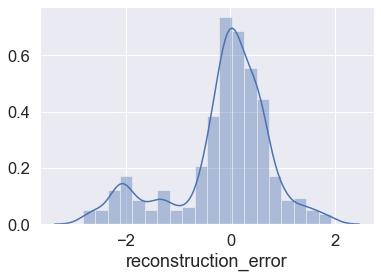

In [28]:
sns.distplot(np.log10(results[results['true_class'] == 1]['reconstruction_error']), bins = 20)
#plt.xlim([0.,.04])

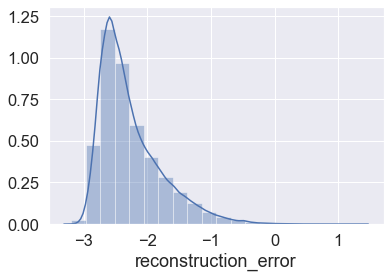

In [29]:
sns.distplot(np.log10(results[results['true_class'] == 0]['reconstruction_error']), bins = 20)
#plt.xlim([0,0.01])

The reconstruction error for the fraudulent transactions is usually higher than that of real transactions. We can choose a cut off of the reconstruction error to be the 90th percentile. This will give us some false positives, but in we'd rather catch fraud than let it slip by. It's okay to ping the customers to ask whether they acutally made the purchase. 

In [30]:
cutoff = np.percentile(results[results['true_class']==0]['reconstruction_error'].values,90)
print(cutoff)

0.02679674292631476


Let's calculate the precision and recall of this naive predictor.

$P = \frac{TP}{TP+FP}$
$R = \frac{TP}{TP+FN}$
$F_1 = \frac{2PR}{P+R}$

In [31]:
results.loc[results['reconstruction_error'] > cutoff, 'predicted_class'] = 1
results.loc[results['reconstruction_error'] <= cutoff, 'predicted_class'] = 0


In [32]:
results.describe()

,reconstruction_error,true_class,predicted_class
count,284807.000000,284807.000000,284807.000000
mean,0.020936,0.001727,0.101356
std,0.409426,0.041527,0.301801
min,0.000635,0.000000,0.000000
25%,0.002407,0.000000,0.000000
50%,0.003972,0.000000,0.000000
75%,0.009432,0.000000,0.000000
max,83.884706,1.000000,1.000000


In [33]:
print(classification_report(results['true_class'].values, results['predicted_class'].values))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    284315
           1       0.02      0.88      0.03       492

    accuracy                           0.90    284807
   macro avg       0.51      0.89      0.49    284807
weighted avg       1.00      0.90      0.95    284807



In [34]:
print("Precision: ", precision_score(results['true_class'].values, results['predicted_class'].values))
print("Recall: ", recall_score(results['true_class'].values, results['predicted_class'].values))
print("F1 score: ",f1_score(results['true_class'].values, results['predicted_class'].values))
print("Accuracy: ",accuracy_score(results['true_class'].values, results['predicted_class'].values))

Precision:  0.01506911005646586
Recall:  0.8841463414634146
F1 score:  0.029633161892435027
Accuracy:  0.8999708574578574


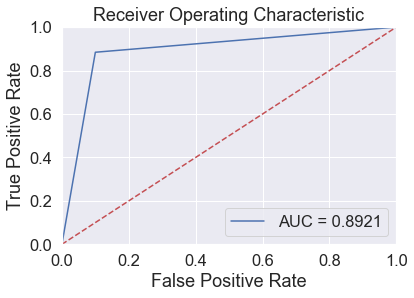

In [35]:
fpr, tpr, thresholds = roc_curve(results.true_class, results.predicted_class)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Let's look at what the actual hidden representation looks like.

In [36]:
hidden_representation = Model(in_, z)

In [37]:
norm_hid_rep = hidden_representation.predict(X_test_scale[:3000])
fraud_hid_rep = hidden_representation.predict(X_fraud_scale)

In [38]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

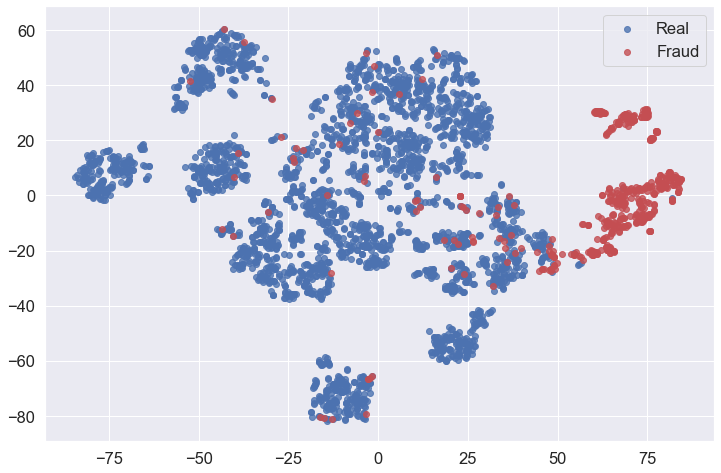

In [39]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(rep_x)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(rep_y == 0), 0], X_t[np.where(rep_y == 0), 1], marker='o', color='b', linewidth='1', alpha=0.8, label='Real')
plt.scatter(X_t[np.where(rep_y == 1), 0], X_t[np.where(rep_y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

plt.legend(loc='best');
plt.show();


Seems like a lot of the fraudulent cases are well separated in the hidden representation but there are a lot that still seem real. 

Could try an logistic regression classifier on the hidden representation features.

In [51]:
norm_hid_rep = hidden_representation.predict(X_train_scale)
fraud_hid_rep = hidden_representation.predict(X_fraud_scale)
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(rep_x, rep_y, stratify = rep_y, test_size=.2, random_state=42)

In [58]:
lr = LogisticRegression(random_state=42)

In [59]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
pred_y = lr.predict(X_test)

print ("")
print ("Classification Report: ")
print (classification_report(y_test, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, pred_y))



Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45491
         1.0       0.92      0.62      0.74        98

    accuracy                           1.00     45589
   macro avg       0.96      0.81      0.87     45589
weighted avg       1.00      1.00      1.00     45589


Accuracy Score:  0.9990787251310623


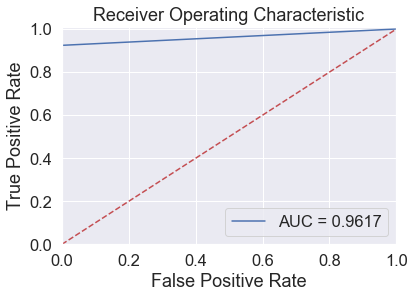

In [61]:
fpr, tpr, thresholds = roc_curve(pred_y, y_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

This is much better than our simple threshhold criterion! Credit card fraud really is hard to detect, but we can at least make some progress! 